Mostly following
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/AKASHKADEL/dcgan-mnist

Imports

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Set device to GPU (cuda) if available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Download mnist dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))])

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

Print some datapoints using matplotlib

Set hyperparameter and load datasets into pytorch DataLoader. This allows to batch data and shuffle after each epoch. It also allows using multiple processors and load data directly into CUDA tensors.

In [8]:
batch_size = 128
num_classes = 10
learning_rate = 0.002
num_epochs = 30
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2
num_gpu = 0

dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

Models

In [9]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)

class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps*4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.network(input)
        return output

Load Generator (CNN) class

In [10]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)

Load Discriminator (CNN) class

In [11]:
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

loss function and optimization functions

In [12]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, size_z, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

Training function

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # get batch-size from actual image batch
        bs = real_images.shape[0]

        # -- train discriminator --

        # reset/clear discriminators gradient
        discriminator.zero_grad()

        # move images to either CPU or GPU
        real_images = real_images.to(device)

        # creates a label tensor filled with 1s
        label = torch.full((bs,), real_label, device=device)

        # get probs for discriminators guess on the real images
        output = discriminator(real_images)

        # get loss for real images. that means it calculates the difference
        # between the output of the model with the current parameter and the
        # target (goal) of what the model is supposed to do
        # output --> current outcome of the model
        # label  --> target of the model
        lossD_real = criterion(output, label)

        # calculates the gradient (using chain-rule)
        # see https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
        lossD_real.backward()

        # Gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations (for real data ) --> D(x)
        D_x = output.mean().item()

        # create noise as an input for the G in order to create fake images
        noise = torch.randn(bs, size_z, 1, 1, device=device)

        # use generator to map input noise to an output that is supposed do become fake images during training
        fake_images = generator(noise)

        # creates a label tensor filled with 0s
        label.fill_(fake_label)

        # get discriminators guess on fake images
        output = discriminator(fake_images.detach())

        # get loss for fake images
        lossD_fake = criterion(output, label)

        # adjust parameter to identify fakes
        lossD_fake.backward()

        # gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations. this time for the fake images that were
        # generated by the generator --> D(G(z))
        D_G_z1 = output.mean().item()

        # calculate loss
        lossD = lossD_real + lossD_fake

        # adjust models (discriminator) parameter
        optimizerD.step()

        # -- train generator --

        # reset/clear generators gradient
        generator.zero_grad()

        # creates a label tensor filled with 1s
        label.fill_(real_label)

        # get discriminators guess on fake images
        output = discriminator(fake_images)

        # get loss for fake images
        lossG = criterion(output, label)

        # adjust parameter to generate fakes
        lossG.backward()

        # gets the mean value of all results from the discriminator to get an average
        # probability of all sample evaluations. this time for the fake images that were
        # generated by the generator --> D(G(z))
        D_G_z2 = output.mean().item()

        # adjust models (generator) parameter
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/469]	Loss_D: 1.4066	Loss_G: 2.7115	D(x): 0.5141	D(G(z)): 0.5091 / 0.0715
[0/30][100/469]	Loss_D: 0.6795	Loss_G: 2.5349	D(x): 0.8312	D(G(z)): 0.3707 / 0.0970
[0/30][200/469]	Loss_D: 0.4843	Loss_G: 3.7226	D(x): 0.9189	D(G(z)): 0.3146 / 0.0302
[0/30][300/469]	Loss_D: 1.0696	Loss_G: 3.2831	D(x): 0.9300	D(G(z)): 0.5912 / 0.0550
[0/30][400/469]	Loss_D: 0.6958	Loss_G: 1.5260	D(x): 0.6861	D(G(z)): 0.2519 / 0.2395
[1/30][0/469]	Loss_D: 0.5668	Loss_G: 3.0654	D(x): 0.8839	D(G(z)): 0.3356 / 0.0581
[1/30][100/469]	Loss_D: 1.3469	Loss_G: 0.6803	D(x): 0.3217	D(G(z)): 0.0949 / 0.5407
[1/30][200/469]	Loss_D: 0.4178	Loss_G: 2.1196	D(x): 0.8053	D(G(z)): 0.1660 / 0.1349
[1/30][300/469]	Loss_D: 1.1321	Loss_G: 1.0218	D(x): 0.4323	D(G(z)): 0.1760 / 0.3936
[1/30][400/469]	Loss_D: 0.9249	Loss_G: 3.0960	D(x): 0.8798	D(G(z)): 0.5178 / 0.0589
[2/30][0/469]	Loss_D: 1.3044	Loss_G: 0.5322	D(x): 0.3618	D(G(z)): 0.1353 / 0.6118
[2/30][100/469]	Loss_D: 0.8416	Loss_G: 1.2018	D(x): 0.54

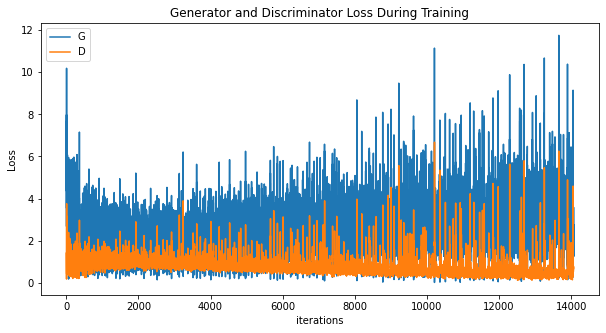

In [14]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

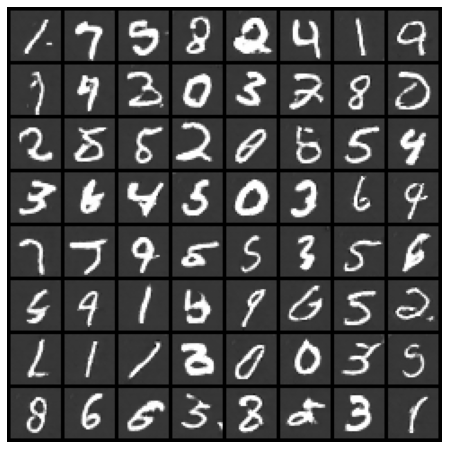

In [15]:
plt.rcParams['animation.embed_limit'] = 100
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [16]:
torch.save(generator.state_dict(), 'model_gen.ckpt')